# This is for data analysis of all things

In [2]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import folium
import numpy as np

/var/folders/rz/jshff6vj0n514y934rv2vj4w0000gn/T/ipykernel_49111/4014710589.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/Library/Python/3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [17]:
'''
Open data.
'''
# All measurement data
df_measurement_data = pd.read_csv('data/combined_measurements.csv', on_bad_lines='skip', low_memory=False)
#print(df_measurement_data.loc[df_measurement_data['prb_id'] == 'Ping'])
#df_measurement_data['prb_id'] = df_measurement_data['prb_id'].astype('int64')

# All the selected probes including their type and location
df_selected_probes = pd.read_csv('data/coordinates_continents_selected_probes.csv')
#df_selected_probes['prb_id'] = df_selected_probes['prb_id'].astype('int64')

# Selected probes joined with measured data
df_probes_measurement_joined = df_selected_probes.merge(df_measurement_data, how='inner', left_on='id', right_on='prb_id')

In [ ]:
'''
Plot the average rtt for the different access technologies.
'''
df_probes_measurement_joined.groupby('type_x')['rtt'].mean().plot(kind='bar')

/var/folders/1l/bh3yv7897j3chh18vpc221k40000gp/T/ipykernel_82277/286168434.py:5: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df_probes_measurement_joined['datetime'] = pd.to_datetime(df_probes_measurement_joined['timestamp'], unit='s')


KeyError: 'Column not found: rtt'

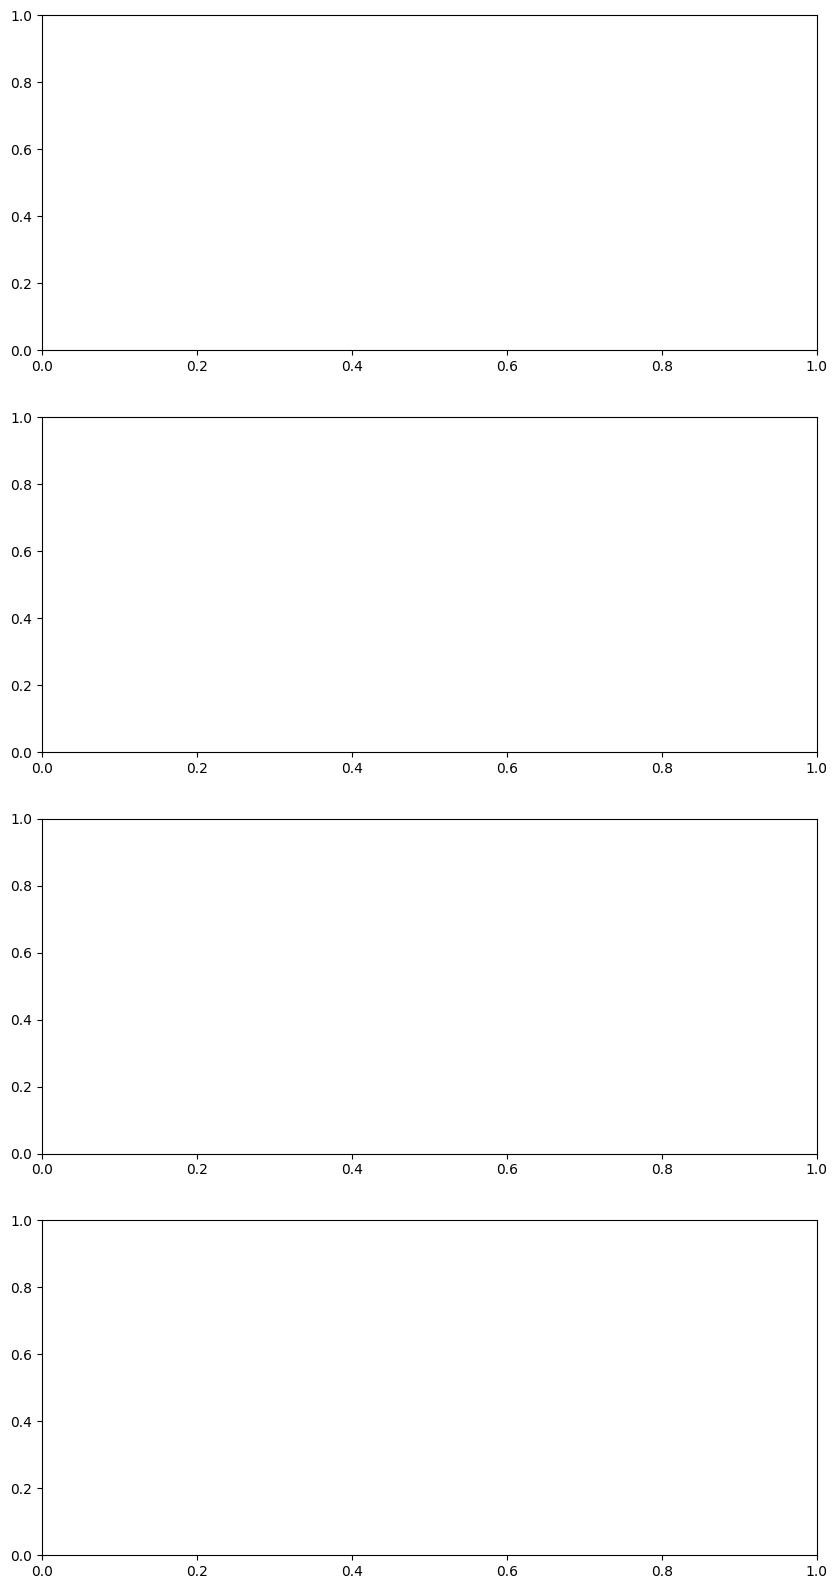

In [11]:
'''
Plot the rtt over the course of a day for each access technology.
'''
# Convert the timestamp to datetime and append to df
df_probes_measurement_joined['datetime'] = pd.to_datetime(df_probes_measurement_joined['timestamp'], unit='s')

# Extracting the hour of the day
df_probes_measurement_joined['hour'] = df_probes_measurement_joined['datetime'].dt.hour

technologies = df_probes_measurement_joined['type_x'].unique()

# Plot the RTT changes for each technology
fig, axs = plt.subplots(len(technologies), 1, figsize=(10, 5*len(technologies)))

for i, tech in enumerate(technologies):
    # Filter the DataFrame by technology
    df_tech = df_probes_measurement_joined[df_probes_measurement_joined['type_x'] == tech]
    
    # Group by hour and calculate the average RTT
    avg_rtt_by_hour = df_tech.groupby('hour')['rtt'].mean()
    
    axs[i].plot(avg_rtt_by_hour.index, avg_rtt_by_hour.values, label=f'Average RTT for {tech}')
    axs[i].set_title(f'RTT Changes Over the Course of a Day for {tech}')
    axs[i].set_xlabel('Hour of the Day')
    axs[i].set_ylabel('Average RTT (ms)')
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout()
plt.show()


In [18]:
'''
Get all the probes which are in the probe to datacenter mapping but did not appear in the measured data.
'''

# Left join
non_matching_probes = df_selected_probes.merge(df_probes_measurement_joined[['prb_id']], how='left', left_on='id', right_on='prb_id', indicator=True).loc[lambda x: x['_merge'] == 'left_only']

# Drop the columns that came from df_probes_measurement_joined and the _merge column
print("Probes without measurements:")
useless_probes = non_matching_probes.drop(columns=['prb_id', '_merge'])
print(useless_probes)

print("Number of probes not actually measuring by type:")
print(useless_probes.groupby(['type'])['type'].count())


Probes without measurements:
     Unnamed: 0       id      type  latitude  longitude      continent  \
0             0  1006833      wifi   10.1385    76.4585           Asia   
1             1  1007500      wifi   48.2475    11.6075         Europe   
2             2  1002768      wifi   45.5215  -122.8095  North America   
3             3  1005958      wifi   35.9615   129.3995           Asia   
4             4  1002493      wifi   42.3085   -83.7185  North America   
..          ...      ...       ...       ...        ...            ...   
377         245  1003444  ethernet   50.0195    14.4495         Europe   
378         246    20059  ethernet   55.6515    37.5695         Europe   
379         247  1001142  ethernet   51.4985     7.0195         Europe   
380         248    55354  ethernet   52.4595     4.5895         Europe   
381         249  1004789  ethernet   52.3815     4.8615         Europe   

    country code  
0             IN  
1             DE  
2             US  
3     

In [17]:
'''
Create a map of all the nodes which did not perform any measurements in order to possibly identify any problems.
'''

# Center map
m = folium.Map(location=[20,0], zoom_start=5)

# Add markers for all probes that are not performing measurements
for index, row in non_matching_probes.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=row['id'],
        icon=folium.Icon(color='blue', icon='map-marker')
    ).add_to(m)
    
# Save map
m.save('maps/useless_probes.html')